# Pre Simulation Testing

Now that we have created our input file we need to verify that our simulation parameters will give a good simulation.

The YAML input file can be found at [input_file](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/documentation/Tutorial_NB/input_files/yukawa_mks_p3m.yaml) and this notebook at [notebook](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/documentation/Tutorial_NB/Pre_Simulation_Testing.ipynb)



In [1]:
# Import the usual libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Choose the plot style MSUstyle or PUBstyle
plt.style.use('PUBstyle')

# Import sarkas
from sarkas.processes import PreProcess

# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'yukawa_mks_p3m.yaml')

## Simulation Parameters

Let's verify our input parameters

In [2]:
preproc = PreProcess(input_file_name)
preproc.setup(read_yaml=True)







________             ______                
__  ___/_____ __________  /_______ ________
_____ \_  __ `/_  ___/_  //_/  __ `/_  ___/
____/ // /_/ /_  /   _  ,<  / /_/ /_(__  ) 
/____/ \__,_/ /_/    /_/|_| \__,_/ /____/  
                                           


An open-source pure-python molecular dynamics suite for non-ideal plasmas.




********************************************************************************
                                 Preprocessing                                  
********************************************************************************

Job ID: yocp
Job directory: SarkasSimulations/yocp_pppm
PreProcessing directory: 
SarkasSimulations/yocp_pppm/PreProcessing

Equilibration dumps directory: 
SarkasSimulations/yocp_pppm/PreProcessing/Equilibration/dumps
Production dumps directory: 
SarkasSimulations/yocp_pppm/PreProcessing/Production/dumps

Equilibration H5MD file: 
SarkasSimulations/yocp_pppm/PreProcessing/Equilibration/dumps/yocp_data

As you can see the output is rather verbose, so let's unpack it.

### Sarkas Figlet
The first screen output is the Sarkas Figlet. This is printed at the beginning of every process by the static method `screen_figlet()` of the `InputOutput` class. The Figlet font and colors are chosen randomly from a predefined set in `sarkas.utilities.io`. This function assumes a white background if you are running a Jupyter notebook, while a dark background in the case of an IPython/Python kernel.

### Storage
Next Sarkas prints the path where the snapshots (`dumps`) and the thermodynamics information of the simulation will be stored. Notice that these are in a directory called `SarkasSimulations/yocp_ppm/PreProcessing`. The actual simulation's dumps and energy files will be in a different directory, see next [page](./Simulation_Docs.ipynb). 

### PARTICLES
In this section we can find info about the particles we are simulating. Importantly we find the physical constants like the plasma frequency and Debye length.

### SIMULATION BOX
Next we have info on the simulation box with relevant lengths and parameters. These include the value of the Wigner-Seitz radius, ``a_ws``, the number of non zero dimensions, and the length of the simulation box sides in terms of ``a_ws`` and its numerical value in the chosen units. 

### ELECTRON PROPERTIES
This section prints thermodynamics quantities as well as dimensionless parameters of the surrounding electron liquid. Here we find the Thomas-Fermi length which is used for the screening parameter $\kappa$ of our Yukawa potential. Formulas for the calculation of each of these quantities can be found in the Electron Properties [page](../../theory/electron_properties.rst) in the Theoretical Background section.

### POTENTIAL
This section prints potential specific parameters. In the case of Yukawa we find the electron temperature used for the calculation of $\lambda_{\rm TF}$ and $\kappa = a_{ws}/\lambda_{\rm TF}$. 
The last line prints the coupling parameter as defined [here](../../theory/coupling_constant.rst)

### ALGORITHM
This section prints information about the choice of our algorithm for calculating the force between particles. The available algorithms are:
- `brute_force`: which consists in looping over all pair of particles. This is the slowest algorithm as it is $\mathcal O(N^2)$.
- `minimum_image`: which consists in calculating all pair of particles that have a distance less or equal than half the box length.
- `PP`: which consists in using a linked cell list to calculate the force between pair of particles that have a distance less or equal than `rc`.
- `PPPM`: the Particle-Particle Particle-Mesh algorithm. Sarkas uses a generalized P3M (or PPPM) algortihm to handle medium to long range interactions. More info can be found in our page on [PPPM](../../theory/PPPM.rst) and DSGM17 in [References](../../theory/references.rst).

There are two parts in this algorithm: particle-particle (PP) and particle-mesh (PM). The former consists of a Linked-Cell-List (LCL). The PM instead consists in depositing the charges on a mesh, move to Fourier space, solve Poisson equation on the mesh and get the electric field, inverse Fourier to return to real space, and finally use the calculated electric field to push the particles. 

As such this algorithm requires nine parameters: the charge assignment order ``Potential.pppm_cao``, the number of aliases of the Fast Fourier Transform (FFT) per direction, ``Potential.pppm_aliases``, the Ewald screening parameter `Potential.pppm_alpha_ewald`, the number of mesh points per direction ``Potential.pppm_mesh``, and the short-range cut-off `Potential.rc`. 

Besides the choice of parameters Sarkas outputs the most relevant information for this algorithm: the number of cells per dimension for the LCL algorithm, the number of particles in the LCL loops, number of neighbors per particle, and the error in the force calculation. This is the error due to our choice of parameters. For more details on the way this is calculated see the page [Force Error](../../theory/force_error.rst). This number is dimensionless since all the variable have been rescaled.
There is no _good_ value for the Force error and it is up to YOU to decide. In Non-Ideal plasmas it is usually chosen to be less than ``1e-5``. In this case we have `Tot Force Error = 6.442673e-06`. 

Below we show how to choose all the above parameters to minimize the force error.

### THERMOSTAT
Next we find information about the thermostat used. At the moment Sarkas supports the Berendsen thermostat only. You can learn more about it on this [page](../Features_files/Berendsen_NB/Berendsen_Thermostat.ipynb).
The parameter `relaxation_timestep` tells us the timestep number at which the thermostat will be turned on. Before then the system will evolve at constant energy. A good number for this is the timestep equivalent to 1 or 2 plasma periods as this allows the system to convert most of its potential energy into kinetic energy and thus reaching its maximum value. Turning on the thermostat once the kinetic energy is maximal is the most efficient way to thermalize.

### INTEGRATOR
The last section prints out info about our choice of Integrator and about the timing of the phases of our simulation. The most important parameters here are the `Total plasma frequency` and `w_p dt`. The total plasma frequency is calculated from 

$$ \omega_{\rm tot} = \left [ \sum_i \omega_i^2 \right ]^{1/2} $$

where $\omega_i$ is the plasma frequency of species $i$. In the case of a one component plasma, as in this case, the total plasma frequency is the same as the plasma frequency printed in the `PARTICLES` section above.
The number `w_p dt` tells us the fraction of inverse plasma frequencies that corresponds to our choice of `dt`. A non-written rule among researchers says that we should choose a `dt` such that $\omega_p dt < 1/ 25$.

### Initialization Times
In this section are indicated the times for the initialization part of the simulation. These times are

- `Potential Initialization` where the all the potential parameters, including the Optimal Green's function in the case of PPPM algorithm, are calculated.
- `Particles Initialization` where the particles positions and velocities are initialized. This includes the case where a specific particles distribution is chosen.

Al of the above output is intended to be a check on the choice of parameters. The real advantage of using `PreProcess` comes next.

## Simulation Estimates

The `PreProcess` class has two primary roles: help in the decision of the above parameters and provide an estimate time of the various phases of a simulation. 

The following line of code runs 20 + 1 timesteps of the equilibration, magnetization (in the case of a magnetized plasma simulation), and production phase to estimate the time of each timesteps, the time of each phase, the time of the entire simulation, and the size of all the dump files. The last line, instead, removes the dump files that have been saved in order to save space. 

In [3]:
preproc.time_n_space_estimates(loops = 20)
preproc.remove_preproc_dumps()



========================== Times Estimates =========================== 

Optimal Green's Function Time: 
0 min 1 sec 49 msec 877 usec 584 nsec 



PP acceleration timer:   0%|          | 0/21 [00:00<?, ?it/s]

Time of PP acceleration calculation averaged over 20 steps:
0 min 0 sec 95 msec 49 usec 39 nsec 



PM acceleration timer:   0%|          | 0/21 [00:00<?, ?it/s]

Time of PM acceleration calculation averaged over 20 steps:
0 min 0 sec 36 msec 450 usec 906 nsec 



  0%|          | 0/21 [00:00<?, ?it/s]

Time of a single Equilibration step averaged over 20 steps:
0 min 0 sec 132 msec 756 usec 886 nsec 



  0%|          | 0/21 [00:00<?, ?it/s]

Time of a single Production step averaged over 20 steps:
0 min 0 sec 132 msec 668 usec 380 nsec 



----------------------- Total Estimated Times ------------------------ 


Equilibration Time: 0 hrs 11 min 3 sec

Production Time: 0 hrs 11 min 3 sec

Total Run Time: 0 hrs 22 min 7 sec


========================= Filesize Estimates =========================

Equilibration:
	H5MD filesize: 0 GB 380 MB 851 KB 795 bytes

Production:
	H5MD filesize: 0 GB 380 MB 851 KB 795 bytes

Total minimum required space: 0 GB 761 MB 679 KB 566 bytes


### Times Estimates
It shows the times needed for the force calculation and the average time for an equilibration and production time step. 

As you can see the calculation of the optimal Green's function takes a relatively long time. Fortunately this needs be calculated only once at the beginning of the simulation. We note also that the PP part takes more than 2x the time it takes for the PM part. This is specific to this hardware and the opposite case could be true on other machines.

Next Sarkas will run `loops` timesteps for each phase to estimate the time of each. These are indicated by the green bars, a nice feature from the `tqdm` package. 
Note that the actual number of loops displayed is 21 instead of 20. The first timestep takes longer than the others because this is the first time that Numba is called. Therefore in order to avoid a skewed mean Sarkas runs one more timestep and averages over the last 20 loops only. 

>**_IMPORTANT:_** that the argument `loops` should be chosen to be larger than `production_dump_step` in order to get a more accurate estimate and not receive an error.

Below the green bars we find the average time of each phase. The equilibration phase takes longer than the production phase due to the presence of a thermostat.

At the end all the estimates are put together to calculate the equilibration, production, and total run times.

The equilibration and production times are then calculated by multiplying the above times by `equilibration_steps` and `production_steps`, respectively. 

>**_NOTE:_**  These times will vary depending on the computer hardware. For this tutorial we used a desktop with Intel Core i7-8700K @ 3.70Ghz and 48GB of RAM running Ubuntu 18.04.

### Filesize Estimates
Next Sarkas will estimate the size of the simulation. It calculates the size of an equilibration and a production dump file and multiplies it by the total number of dumps. as mentioned above the last line takes care of removing dump files in order to save space.

This simulation should take about ~1.5 GB of space.

## Simulation Parameters Optimization

Plasmas main characteristic is the long range Coulomb interaction between particles. Sarkas uses the generalized PPPM algortihm which requires several parameters. The most important ones are: the short-range cut-off ($r_c$), the Ewald parameter ($\alpha$), the number of mesh points per direction ($M_x, M_y, M_z$).

MD simulations are often performed with sub-optimal parameters which lead to inefficient and longer runs. Furthermore, optimal parameters are not easily found as they depend not only on the type of problem under investigation, but also on the available computational hardware. Researchers are thus left to use trial-and-error approaches or rely on colleagues’ suggestions to choose simulation’s parameters.
Sarkas `PreProcessing` class aims at simplifying the search for optimal parameters. In order to find the optimal parameters we need to define a metric. Sarkas has chosen the simulation time and force error as metrics to choose the optimal parameters.

The following code runs few simulation timesteps for each of the combination of PPPM parameters and calculates their average time and force error. This routine can be run directly in the `.run` method simply by setting the option `timing_study = True`.

In [5]:
# Uncomment these two lines and change them based on your preferences.
# !!!! Make sure to include the dtype = int64 if you are using a Windows machine !!!!
preproc.pm_meshes = np.logspace(3, 6, 4, base = 2,  dtype=np.int64)
preproc.pm_caos = np.array([ 2, 3, 6], dtype=np.int64)

preproc.timing_study_calculation()

Looping over the PM meshes:   0%|          | 0/4 [00:00<?, ?it/s]

### Timing Study
As mentioned above Sarkas calculates the force error and the computation times for the combination of parameters: mesh sizes, charge assignment order (cao) and lcl cells. The array of mesh sizes and cao can be changed by setting `preproc.pm_meshes` and `preproc.pm_caos` to the desired arrays. For each mesh size Sarkas sets 

        pppm_alpha_ewald = 0.3 * m / parameters.box_lengths.min()

and then calculates `pp_cells` as given by

        max_cells = int(0.5 * parameters.box_lengths.min() / parameters.a_ws)
        pp_cells = np.arange(3, max_cells, dtype=int)

Since this is a long process Sarkas prints out to screen the progress. At the end Sarkas saves all the information into a dataframe. The last line in the output tells you where to find it. 

Let's print the first ten lines

In [6]:
preproc.dataframe.head(10)

,pp_cells,r_cut,pppm_alpha_ewald,pppm_cao_x,pppm_cao_y,pppm_cao_z,M_x,M_y,M_z,Mesh volume,...,h_y alpha,h_z alpha,h_M a_ws^3,G_k time [s],pp_acc_time [s],pm_acc_time [s],tot_acc_time [s],pppm_pp_error [measured],pppm_pm_error [measured],force error [measured]
0,3,1.317368e-10,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.912554,0.011108,0.923662,3.015890e-07,6.471764e-10,3.015897e-07
1,4,9.880259e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.359081,0.011108,0.370189,4.607733e-07,6.471764e-10,4.607737e-07
2,5,7.904207e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.182270,0.011108,0.193378,5.864444e-07,6.471764e-10,5.864448e-07
3,6,6.586839e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.104989,0.011108,0.116097,6.892739e-07,6.471764e-10,6.892742e-07
4,7,5.645862e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.067165,0.011108,0.078273,7.767845e-07,6.471764e-10,7.767848e-07
5,8,4.940130e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.045229,0.011108,0.056337,8.536145e-07,6.471764e-10,8.536148e-07
6,9,4.391226e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.032555,0.011108,0.043662,9.226594e-07,6.471764e-10,9.226596e-07
7,10,3.952104e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.024386,0.011108,0.035494,9.857980e-07,6.471764e-10,9.857982e-07
8,11,3.592822e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.019040,0.011108,0.030148,1.044301e-06,6.471764e-10,1.044301e-06
9,12,3.293420e-11,6.072715e+09,2,2,2,8,8,8,512,...,0.3,0.3,0.027,0.009894,0.015463,0.011108,0.026570,1.099062e-06,6.471764e-10,1.099062e-06


Let's make some plots

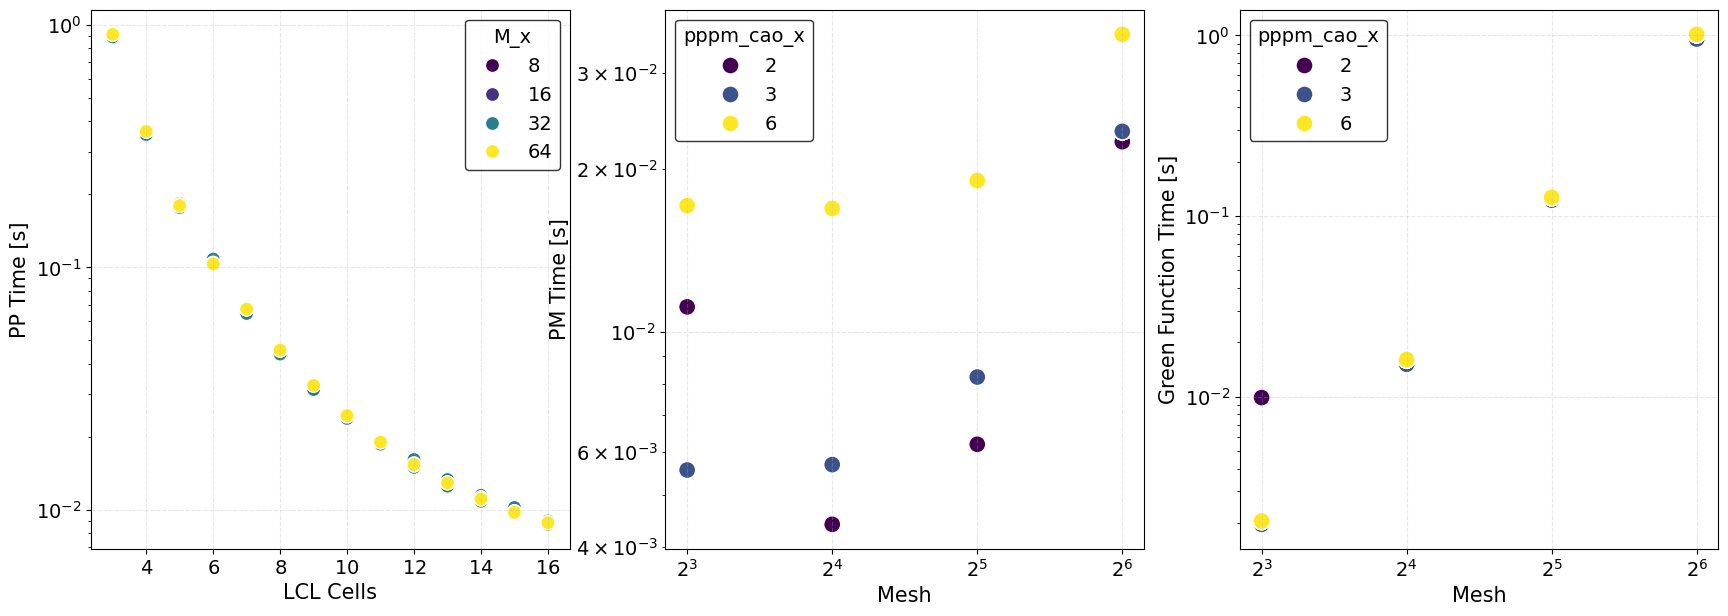

In [7]:
preproc.make_timing_plots()

The plot on the right is a plot of the computation times of the PP for part as a function of LCL cells for different mesh sizes. It looks like the mesh size does not affect the PP time significantly. This is because the LCL algorithm's time scales as

$$ \tau_{\rm LCL} \propto \left (\frac{4\pi n}{3} \frac{L^3}{N_c^3} \right ) N,$$

where $N_c = L/r_c$ is the number of cells per dimension (assumed to be the same in all directions) obtained from the cutoff radius, $r_c$. 

The center plot is a log-log plot of the times of the PM part as a function of the mesh size (`M_x = M_y = M_z`) for different `pppm_cao` values. Note that the xticks are given in powers of 2. This is because FFT algorithms are the most efficient when the number of mesh points is a multiple of a power of 2. However, in order to give a more realistic estimate, we have chosen mesh sizes that are not multiple of powers of 2. At fixed `pppm_cao` the FFT computation time scales as 

$$ \tau_{\rm FFT} \propto (M_x M_y M_z) \log_2( M_x M_y M_z). $$

This equation comes from the FFTW documentation [page](http://www.fftw.org/benchfit). The vertical variation in times is due to the interpolation of the charge density on the mesh and as such depends on the value of `pppm_cao` (assumed that `pppm_cao = pppm_cao_x = pppm_cao_y = pppm_cao_z`),

Finally, the left plot shows the time required to compute the optimal Green's function as a function of the mesh size at different `pppm_cao` values. This time again does not depend strongly on the value of `pppm_cao` since in this case there is no loop on `pppm_cao` and it only appears as the exponent the computation of the Green's function.

Note that currently the `timing_study_calculation` method uses cubic meshes, Sarkas dev team is hoping to improve this method to include different geometries. PR are welcome!

Let's make some more plots.

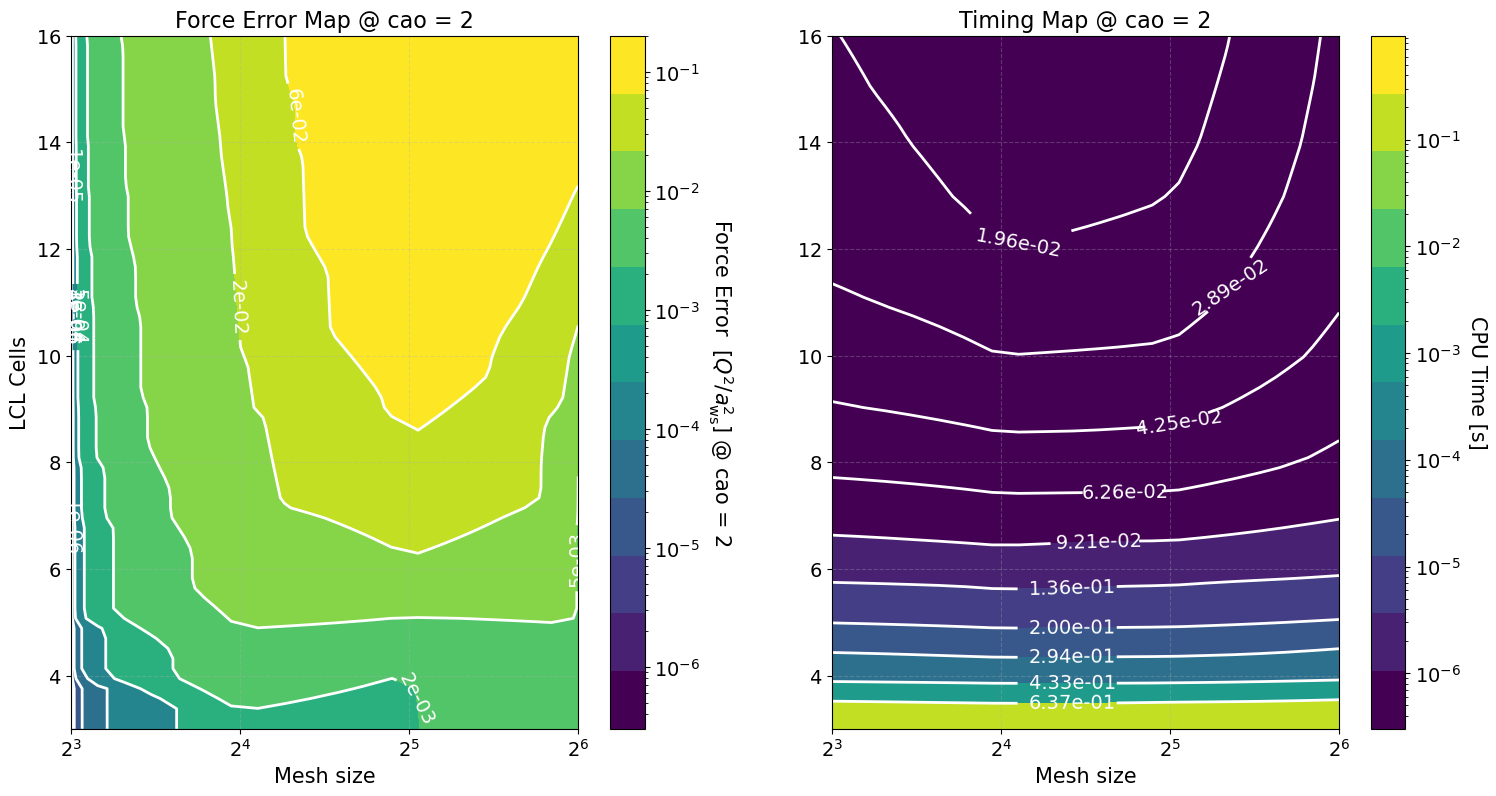

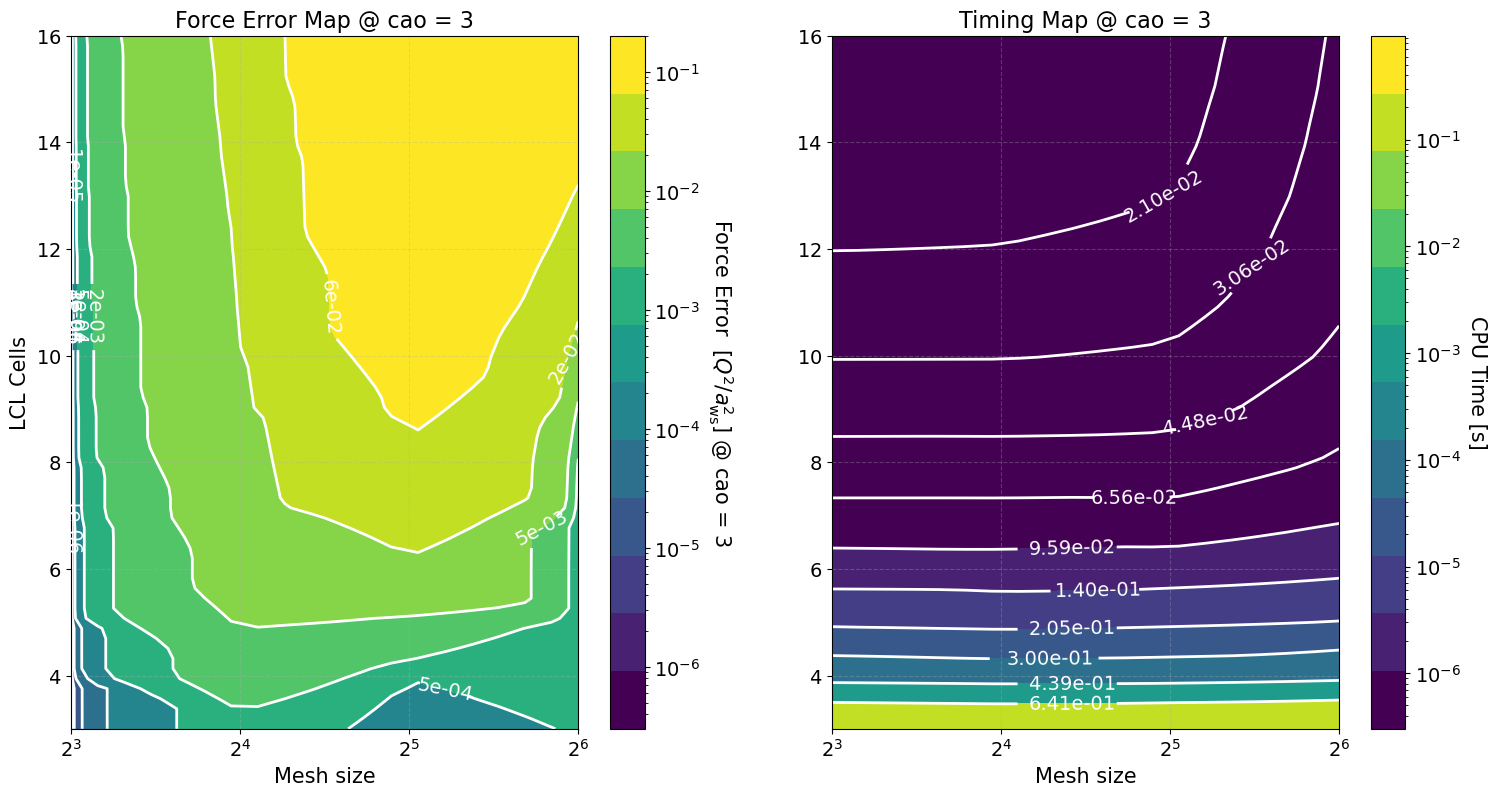

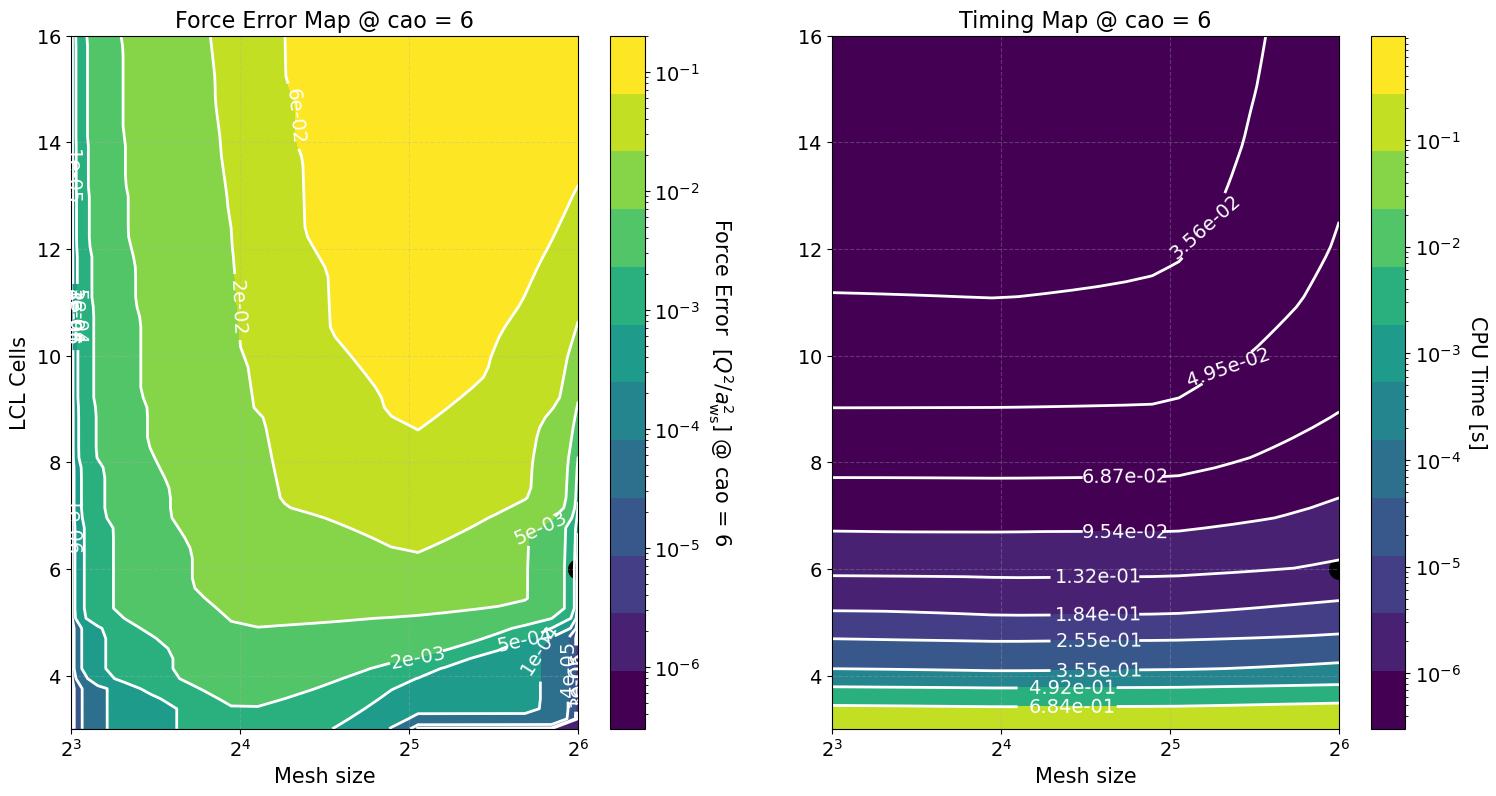

In [8]:
preproc.make_force_v_timing_plot()

The above figures are color maps of total force error (left) and the total acceleration time (right) as functions of the LCL cells and mesh size (`M_x`). There is a plot for each `pppm_cao_x`. 
The force error is given by $\Delta F_{\rm tot}$

$$ \Delta F_{\textrm{tot}} = \sqrt{ \Delta F_{\rm PP}^2 + \Delta F_{\rm PM}^2 }, $$

where $\Delta F_{\rm PP(PM)}$ is the force error of the PP (PM) part, see [Force Error](../../theory/force_error.rst) for more details.

These maps are created using `matplotlib.pyplot.contourf()` function by passing the data in the columns `tot_acc_time [s]` and `force_error [measured]` of the dataframe and interpolating using `scipy.interpolate.griddata`, hence, the staggered contour lines.

As expected the maps indicate that the smaller the force error the larger the computation time. These plots are meant to provide an overview of the parameter space and help you decide the optimal value for $ M_x $ and $ N_c $.

The black dot in the second to last figure indicates our original choice of paramaters. If we pay close attention we notice that the force error is larger than the one calculated in the beginnning of this notebook. This is because while the number of cells is the same in both case the cutoff radius is not. The cutoff radius chosen in the input file is smaller than the one used for producing the above plots which is calculated from $r_c = L/N_c$. 

In order to fine tune our choice of parameters we run the next line


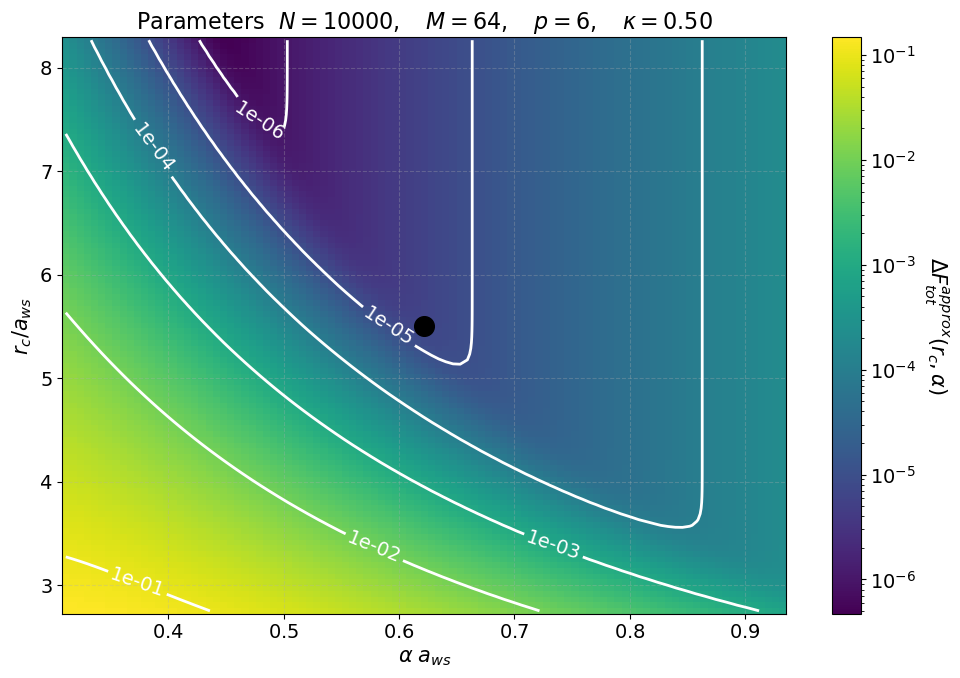

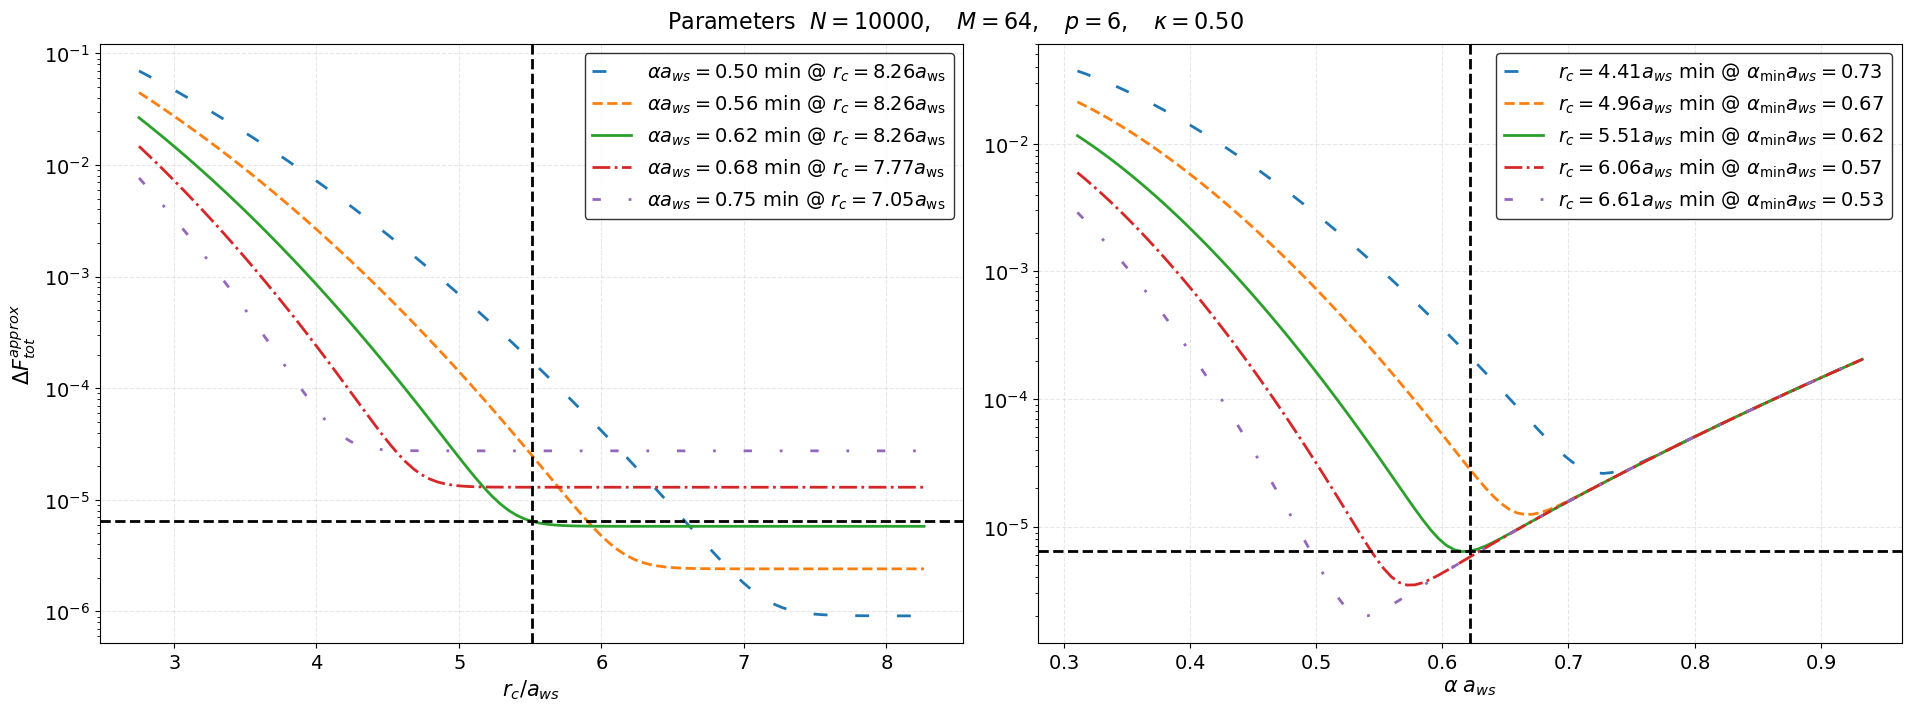

In [9]:
preproc.pppm_approximation()

### Force Error
The first figure is a contour map in the $(r_c,\alpha)$ parameters space of 

$$ \Delta F_{\textrm{tot}}^{(\textrm{approx})}( r_c, \alpha) = \sqrt{ \Delta F_{\rm PP}^2 +
            ( \Delta F_{\rm PM}^{(\textrm{approx})} ) ^2 }. $$
            
$\Delta F_{\rm PM}^{(\textrm{approx})}$ is calculated from an approximation of the PM force error, hence the superscript $\rm approx$, and its functional form is different than the one calculated in $\Delta F_{\rm PM}$, see [Force Error](../../theory/force_error.rst) for more detail. The numbers on the white contours indicate the value of $\Delta F_{\textrm{tot}}^{(\textrm{apprx})}$ along those lines and the black dot, again, indicates our choice of parameters. Notice that our parameter choice now falls in the region in between `1e-5` and `1e-6` as expected, recall `Tot Force Error = 6.442673e-06`. This plot tells us that if we want a force error of the order 1e-6 we need to choose values that fall into the small purple triangle at the top.

However, our choice of parameters while being good, it might not be optimal. In order to find the best choice we look at the second figure.

The left panel is a plot of $\Delta F_{\textrm{tot}}^{(\textrm{approx})}$ vs $r_c/a_{\rm ws}$ at
five different values of $\alpha a_{\rm ws}$ while the right panel is a plot of
$\Delta F_{\textrm{tot}}^{(\textrm{approx})}$ vs $\alpha a_{\rm ws}$ at five different values of $r_c/a_{\rm ws}$. The vertical black dashed lines indicate our choice of $\alpha a_{\rm ws}$ and $r_c/a_{\rm ws}$. The horizontal black dashed lines, instead, indicate the value `Tot Force Error = 6.442673e-06`.

These plots show that our analytical approximation is a very good approximation and that our choice of parameters is optimal as the intersection of the dashed lines falls exactly in the minimum of the curves. From the left panel we find that larger values for $r_c = 5.51$ lead to an inefficient code since we will be calculating the interaction for many more particles without actually reducing the force error. Similarly, the right panel shows that our choice of $r_c$ is close to optimal given $\alpha a_{ws} = 0.614$.

Some good rules of thumb to keep in mind while choosing the parameters are

- larger (smaller) $\alpha$ lead to a smaller (larger) PM error, but to a larger (smaller) PP error,
- larger (smaller) $r_c$ lead to a smaller (greater) PP part but do not affect the PM error,
- keep an eye on the PM and PP calculation times.
- larger $r_c$ lead to a longer time spent in calculating the PP part of the force since there are more neighbors,
- larger or smaller $\alpha$ do not affect the PM calculation time since this depends on the number of mesh points,
- choose the number of mesh points to be a power of 2 since FFT algorithms are most efficient in this case.

>**_NOTE:_**  The above investigation is useful in choosing the parameters $r_c$ and $\alpha$ for fixed values of the charge approximation order, $p$, the number of mesh points, $M_x = M_y = M_z$, and number of aliases $m_x = m_y = m_z$.


## Post Processing

All the above information are needed in order to run a simulation and produce data to be analyzed in the post-processing phase. However, the optimal choice of the above parameters does not necessarily indicate that our desired physical observable is calculated correctly. Thus, we need to verify that our choices lead to the desired physical result.

Let's run the next code cell to print the parameters of the physical observables that we decided to calculate in the `PostProcessing` section of the YAML file. 

In [ ]:
# preproc.postproc_estimates()

### Radial Distribution Function

The most common physical observable is the Radial Distribution Function (RDF). Our choice of `Parameters.rdf_nbins : 500` and `Potential.rc : 6.2702e-11` leads to `dr = 0.0110 a_ws` and `r_max = 5.5100 a_ws`. If we desire to have a larger `r_max` we will need to increase `potential.rc`. As mentioned above this might lead to an inefficient force calculation, but the force error plots can help us find an optimal `alpha` for a larger `rcut`

### Static Structure Factor

The Fourier transform of the RDF leads to the Static Structure Factor (SSF). The important parameters for the SSF is the desired range of wavevectors to calculate. The output shows the chosen number of harmonics of the smallest wavevector in each of cartesian directions. These are the same values in the YAML file. 

Next, we find the total number of $\mathbf k$ (vectors) that will be calculated. This number corresponds to the total number of combinations of the three harmonics directions, `n_x * n_y * n_z - 1` .

The smallest $\mathbf k$ vector that can be fitted int the simulation box is given by the length of the longest side of the simulation box, $L$. This is computed from the total number of particles, $N$.

$$ k_{\rm min} = \frac{2\pi}{L} \approx \frac{3.9}{N^{1/3}}$$

In this case, $k_{\rm min} a_{\rm ws} = 0.1809 $, if we need to investigate smaller wavevectors we need to increase the number of particles. The above equation can be used to find the value of $N$ for the desired $k_{\rm min}$ value.

The largest wavevector, instead, is defined by our choice of `angle_averaging`. This parameter can take three values `principal_axis`, `custom`, `full`. The default value for this parameter is `principal_axis`. More about this parameter will be explained in the [Post Processing notebook](./Post_Processing_Docs.ipynb). For the moment we mention that in the case of `angle_averaging = principal_axis` the maximum value is calculated as

$$ k_{\rm max} = \frac{2 \pi}{L} \sqrt{3} n_x, $$

while in the case `angle_averaging = full` as

$$ k_{\rm max} = \frac{2 \pi}{L} \sqrt{n_x^2 + n_y^2 + n_z^2}. $$

### Dynamic Structure Factor and Current Correlation Function

These two functions depend on the same parameters. However, it can be the case that only one of the two is calculated, hence, a section for each of them. The parameters are divided in two sections, frequency and wavevector constants. The wavevectors constants are the same as those in SSF. This is due to the fact that the $\mathbf k$ data is saved once computed the first time. Any subsequent calculation requiring this data will read in the saved data and not recompute it. Therefore it is important to check that the parameters in the YAML file are the same. 

As per the frequency constants, the first parameters is the number of slices. This indicates the number in which to divide the timeseries data. A DSF (or CCF) will be calculated for each slice and the final result will be an average over all the slices. The important parameters are then the frequency step and the maximum frequency calculated from the FFT. For each of these values, the corresponding equation is given so to help the user decide the correct parameters.
The maximum frequency is given by 
 
$$ \omega_{\rm max} = \frac{\pi}{d_s \Delta t } $$

where $\Delta t$ is the timestep and $d_s$ the snapshot interval (`prod_dump_step`). The frequency step instead is 

$$ \Delta \omega = 2\pi \frac{d_s N_s}{M_T \Delta t} $$

where $N_s$ is the number of slices (`no_slices`), $M_T$ the number of timesteps (`production_steps`).

## Put it all together


All the above methods can be automatically run by seeting options to true in the `PreProcess.run()` method. 

    preproc.run(
        timing=True,          # time estimation, default is True
        loops = 20,           # the number of timesteps to average, Default is 10
        timing_study = True,  # Run the timing_study_calculation. Default is False
        pppm_estimate = True, # Run pppm_approximation. Default is False
        remove = True,        # Save some space. Default is False
        postprocessing = True # Run postproc_estimates. Default is False.
               )
